In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from collections import Counter
from sklearn.datasets import make_blobs
pd.options.display.max_columns = 70
sns.set_style("whitegrid")
% matplotlib inline

In [2]:
% cat ./ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [2]:
names = ["user_id", "movie_id", "rating", "timestamp"]
u_data_df = pd.read_csv("ml-100k/u.data", delimiter='\t', header=None, names=names)

names = [
    "movie_id","movie_title","release_date","video_release_date",
    "IMDb_URL","unknown","Action","Adventure","Animation",
    "Children's","Comedy","Crime","Documentary","Drama","Fantasy",
    "Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi",
    "Thriller","War","Western"
]
u_item_df = pd.read_csv("ml-100k/u.item", delimiter='|', header=None, names=names, encoding="ISO-8859-1")

names = ["user_id", "age", "gender", "occupation", "zip_code"]
u_user_df = pd.read_csv("ml-100k/u.user", delimiter="|", header=None, names=names)

In [6]:
% cat ml-100k/u.genre

unknown|0
Action|1
Adventure|2
Animation|3
Children's|4
Comedy|5
Crime|6
Documentary|7
Drama|8
Fantasy|9
Film-Noir|10
Horror|11
Musical|12
Mystery|13
Romance|14
Sci-Fi|15
Thriller|16
War|17
Western|18



## 職業の分布

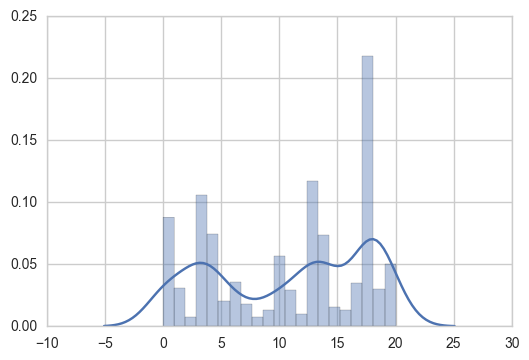

In [10]:
# sns.distplot(x=np.array(u_user_df["occupation"]))
occupation = np.array(u_user_df["occupation"])
occupation_list = np.unique(occupation)
occupation_dict = dict(zip(occupation_list, np.arange(0, len(occupation_list))))
x = [occupation_dict[i] for i in occupation]
sns.distplot(x, bins=len(occupation_list))

## 1人がどれだけratingをしているかのヒストグラム

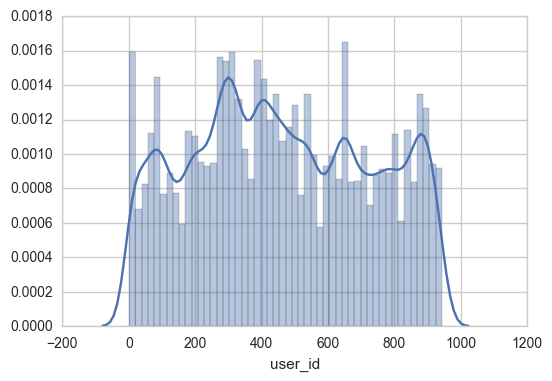

In [44]:
sns.distplot(u_data_df["user_id"])

### 協調フィルタリングの共通アイテム数
- 相関係数を出すための共通アイテム数を決める
 - 少ないと相関係数の値が跳ね上がる
 - 例: *np.corrcoef([5,3],[4,5]) -> array([[ 1., -1.],[ 1., -1.]])*
- 適切な共通アイテム数を探すために, 統計量とプロットを行う
- 下図の結果より共通アイテム数を60とする

レビュー回数の平均: 106.04453870625663
レビュー回数の中央値: 65.0
レビュー回数の分散: 10176.413710895373
レビュー値の平均: 3.52986
レビュー値の中央値: 4.0
レビュー値の分散: 1.2671283804


[(0, 100)]

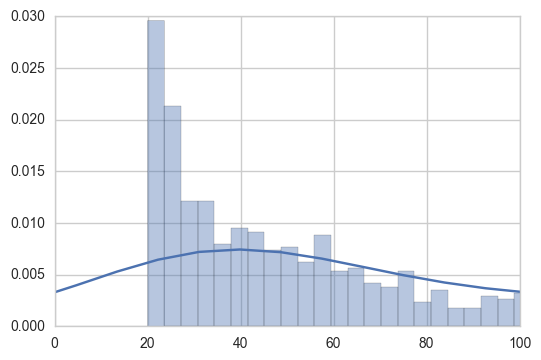

In [133]:
# 一人あたりの平均レビュー数
user_rating_times = dict(Counter(u_data_df["user_id"]))
rating_times_mean = np.mean(list(user_rating_times.values()))
rating_times_median = np.median(list(user_rating_times.values()))
rating_times_var = np.var(list(user_rating_times.values()))
print("レビュー回数の平均: {}".format(rating_times_mean))
print("レビュー回数の中央値: {}".format(rating_times_median))
print("レビュー回数の分散: {}".format(rating_times_var))

# 一人あたりのレビューの値
rating_mean = np.mean(u_data_df["rating"]) # 平均値
rating_median = np.median(u_data_df["rating"]) # 中央値
rating_var = np.var(u_data_df["rating"])  # 分散
print("レビュー値の平均: {}".format(rating_mean))
print("レビュー値の中央値: {}".format(rating_median))
print("レビュー値の分散: {}".format(rating_var ))

# レビュー回数のヒストグラム
sns.distplot(list(user_rating_times.values()), bins=200).set(xlim=(0, 100))

63


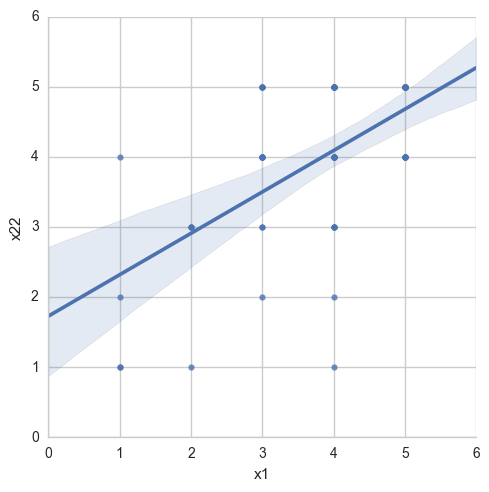

In [177]:
common_movie_index = np.where((some_df.ix[1]!=0)&(some_df.ix[22]!=0))[0]
x1 = np.array(some_df.ix[1])[common_movie_index]
x22 = np.array(some_df.ix[22])[common_movie_index]
x1x22_df = DataFrame({"x1":x1, "x22":x22}, index=common_movie_index)
sns.lmplot("x1", "x22", data=x1x22_df)
print(len(common_movie_index))

In [44]:
# あるuserとuserの相関をプロットする
def corrcoef_user_plot(user_movie_rating_df, user_id1, user_id2):
    common_movie_index = np.where((user_movie_rating_df.ix[user_id1]!=0)&(user_movie_rating_df.ix[user_id2]!=0))[0]
    x1 = np.array(user_movie_rating_df.ix[user_id1])[common_movie_index]
    x2 = np.array(user_movie_rating_df.ix[user_id2])[common_movie_index]
    x1x2_df = DataFrame({"x1":x1, "x2":x2}, index=common_movie_index)
    sns.lmplot("x1", "x2", data=x1x2_df)
    # print(len(common_movie_index))

In [12]:
# u_dataを引数に, 行:user_id, 列:movie_id とするDataFrameを返す
def user_movie_rating_df(u_data_df, u_user_df):
    movie_id = np.unique(np.int_(u_data_df["movie_id"]))
    df = DataFrame(columns=movie_id)
    for user_id in u_user_df["user_id"]:
        movie_rate_df = u_data_df[u_data_df["user_id"]==user_id][["movie_id", "rating"]]
        d = dict(zip(np.int_(movie_rate_df["movie_id"]), movie_rate_df["rating"]))
        df = df.append(DataFrame([d]))
    df = df.fillna(0).astype(int)
    df.index = range(1, len(df)+1)
    return df

In [41]:
# user_idが1と他の相関係数
def get_user_corrcoef(target_user_id, user_movie_rating_df):
    user_corrcoef = {}
    for index, row in user_movie_rating_df .iterrows():
        if index != target_user_id:
            user1, user2 = np.array(user_movie_rating_df.ix[target_user_id]), np.array(user_movie_rating_df.ix[index])
            common_movie_index  = np.where((user1!=0)&(user2!=0))[0]
            if len(common_movie_index) > 60: # 共通のアイテム数の下限60個
                common_movie_id = common_movie_index + 1
                corrcoef = np.corrcoef(user1[common_movie_index], user2[common_movie_index])[0][1]
                user_corrcoef[index] = corrcoef
            else:
                user_corrcoef[index] = 0
    return user_corrcoef

In [39]:
# 相関の強さからuserを探す
def get_corrcoef_df(user_corrcoef):
    corrcoef_df  = DataFrame({"user_id": list(user_corrcoef.keys()), "corrcoef": list(user_corrcoef.values())})
    sorted_corrcoef = sorted(corrcoef_df["corrcoef"], reverse=True)
    corrcoef_df = corrcoef_df.sort_values(by="corrcoef", ascending=False)
    return corrcoef_df

In [145]:
# レコメンドするmovie_idと相関が強いuser_idを返す
def get_recommendation(corrcoef_df, user_movie_rating_df, target_user_id):
    recommendation_user_id = np.array(corrcoef_df["user_id"])[0] # 相関の上位1つ
    # 相関の強いユーザが高評価(rating5)していて, 自分が観ていない物をレコメンドする
    recommendation_movie_id = np.where((user_movie_rating_df.ix[target_user_id]==0)&(user_movie_rating_df.ix[recommendation_user_id]==5))[0]
    recommendation_movie_id += 1 # 映画のidは1スタートなので
    return recommendation_user_id, recommendation_movie_id

In [146]:
# 精度検証 (２乗誤差平均を返す)
def check_square_error_average(test_user_movie_rating_df, target_user_id, recommand_movie_id):
    target_user_rating = np.array(test_user_movie_rating_df.ix[target_user_id][movie_id])
    # 評価には観ていたものだけを使う
    target_user_rating = target_user_rating[np.nonzero(target_user_rating)]
    # get_recommendationの際に, 相関の強いユーザが高評価(rating 5)の物を取ってきたので
    # 評価値5との誤差を返す
    return np.mean(np.square(target_user_rating-5))

## 実行の手順

In [ ]:
# データの読み込み
train_user_movie_rating_df = user_movie_rating_df(train_df, u_user_df)
test_user_movie_rating_df = user_movie_rating_df(test_df, u_user_df)

In [ ]:
# 検証用データ
train_df = pd.read_csv("./ml-100k/u1.base", delimiter='\t', header=None, names=["user_id", "movie_id", "rating", "timestamp"])
test_df = pd.read_csv("./ml-100k/u1.test", delimiter='\t', header=None, names=["user_id", "movie_id", "rating", "timestamp"])

精度(２乗誤差平均): 1.3333333333333333


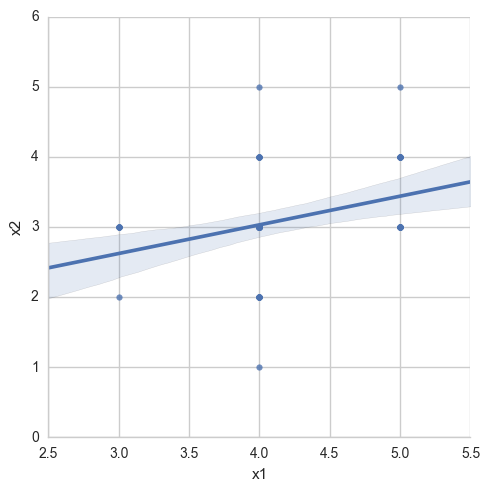

In [158]:
# OverView
target_user_id = 60
user_corrcoef = get_user_corrcoef(target_user_id, train_user_movie_rating_df)
corrcoef_df = get_corrcoef_df(user_corrcoef)
recommand_user_id, recommand_movie_id = get_recommendation(corrcoef_df, train_user_movie_rating_df, target_user_id)
corrcoef_user_plot(train_user_movie_rating_df, target_user_id, recommand_user_id)
print("精度(２乗誤差平均): {}".format(check_square_error_average(test_user_movie_rating_df, target_user_id, recommand_movie_id)))

## 推薦システムの前提
- 入力される情報
  - 職業
  - 年齢
  - 性別